In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Preprocessing

Some preliminary preprocessing: read the file, get rid of missing values, etc

In [2]:
pd.set_option('display.max_columns', None) #so the maximum number of columns are displayed in .head()

In [3]:
#Loading the dataset on a datafdrame data
data = pd.read_csv("Android_Malware.csv")
data = data.drop(['Unnamed: 0'], axis = 1)

/var/folders/5z/1dd847w96pb2t3c9_r9mc_y40000gn/T/ipykernel_55932/2046316586.py:2: DtypeWarning: Columns (56,58,63) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("Android_Malware.csv")


In [4]:
data.columns = [i.strip() for i in data.columns] # stripping all the whitespaces from the column names

In [5]:
#Dropping all the missing values from data
print(data.isnull().sum())
data = data.dropna()

Flow ID             1
Source IP           0
Source Port         0
Destination IP      0
Destination Port    0
                   ..
Idle Mean           4
Idle Std            4
Idle Max            4
Idle Min            4
Label               0
Length: 85, dtype: int64


In [6]:
#Dropping Android_Adware and Android_Scareware
data['Label'].unique()
labels_to_remove = ['Android_Adware', 'Android_Scareware']
data = data[~data['Label'].isin(labels_to_remove)]
for column in data.columns:
    if 'Timestamp' in column:
        data = data.drop(column, axis = 1)

In [7]:
from sklearn.preprocessing import LabelEncoder

data = data.reset_index(drop=True)

label_encoder = LabelEncoder()
y_ = label_encoder.fit_transform(data['Label'])

# revert the list to make 1 stand for malware and 0 for benign software
y = [0 if item == 1 else 1 for item in y_]

X = data.drop(['Label'], axis = 1)


# x = pd.DataFrame(encoder.fit_transform(x, y), columns = x.columns)



In [8]:
# print(X)
# print(y)

Split the dataset, and then perform SMOTE and other preprocessing steps

In [9]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from category_encoders import TargetEncoder


# Split dataset 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)

# transform non numerical data
non_numerical_columns = X_train.select_dtypes(exclude=['number']).columns.tolist()
ordinal_encoder = OrdinalEncoder()
for column in non_numerical_columns:
    X_train[column] = ordinal_encoder.fit_transform(X_train[[column]].astype(str))
    X_test[column] = ordinal_encoder.fit_transform(X_test[[column]].astype(str))


# Apply SMOTE to ONLY TRAIN SET
X_train, y_train = smote.fit_resample(X_train, y_train)

# Data normalization after oversampling (both train and test set)
scaler = MinMaxScaler()
X_train_arrays = scaler.fit_transform(X_train)
X_test_arrays = scaler.fit_transform(X_test)
X_train = pd.DataFrame(X_train_arrays, columns=X_test.columns) # using X_test here because they share the same columns
X_test = pd.DataFrame(X_test_arrays, columns=X_test.columns)



[Data Analysis] Numbers of each class


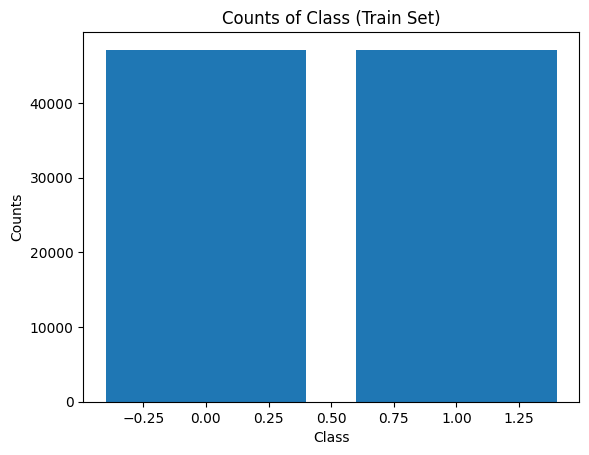

In [10]:
from collections import Counter

# See if the dataset is balanced after applying SMOTE
print("[Data Analysis] Numbers of each class")
class_counts = Counter(y_train)
labels = list(class_counts.keys())
counts = list(class_counts.values())
plt.bar(labels, counts)
plt.title('Counts of Class (Train Set)')
plt.xlabel('Class')
plt.ylabel('Counts')
plt.show()

#### Feature Selection Using Heuristic Search Algorithms

In [23]:
import pandas as pd
import numpy as np
import random
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectPercentile, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Use VarianceThreshold to remove features that only has one value (default threshold will do this)
# train and test sets are sharing the same features
vt_sel = VarianceThreshold()
vt_sel.fit_transform(X_train)
remaining_features_names = X_train.columns[vt_sel.get_support(indices=True)].tolist()
X_train = X_train[remaining_features_names]
X_test = X_test[remaining_features_names]

def _get_score_of_features_set(X, y):
    clf = LogisticRegression(max_iter=1000, n_jobs=-1, solver='sag')
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy', n_jobs=-1)
    scores_mean = np.mean(scores)
    return scores_mean

def random_search(X, y, all_features, max_iteration):
    best_features = []
    best_score = 0
    for i in range(max_iteration):
        if i+1 % 10 == 0 or i == 0:
            print(f"[RS] iteration #{i+1}/{max_iteration}")
        random_features = random.sample(all_features, k=random.randint(len(all_features)//15, len(all_features))) # can change the range of this number
        score = _get_score_of_features_set(X[random_features], y)
        if score > best_score:
            best_score = score
            best_features = random_features
    return best_features

def _get_neighbor_status_for_sa(feature_list, all_features):
    features = feature_list
    # randomly add/remove one feature to/from the list
    choice = random.choice([0, 1])
    if len(feature_list) < 5:
        # cannot have an empty list
        choice = 1
    if choice == 1:
        flag = True
        while flag:
            new_feature = random.choice(all_features)
            if new_feature not in feature_list:
                features.append(new_feature)
                flag = False
    else:
        random_index = random.randrange(len(feature_list))
        features = feature_list.pop(random_index)
    return feature_list

def simulated_annealing(X, y, all_features, initial_temperature, min_temperature, cooling_rate, max_iteration):
    best_features = []
    best_score = 0
    temperature = initial_temperature

    current_features = random.sample(all_features, k=len(all_features)//15) 
    current_score = _get_score_of_features_set(X[current_features], y)

    while temperature > min_temperature:
        print(f"[SA] Current temperature: {temperature}")
        for i in range(max_iteration):
            new_features = _get_neighbor_status_for_sa(current_features, all_features)
            new_score = _get_score_of_features_set(X[new_features], y)

            if new_score > current_score:
                current_features = new_features
                if new_score > best_score:
                    best_features = new_features
            else:
                probability = math.exp((current_score - best_score) / temperature) # metropolis criterion
                if random.random() < probability:
                    current_features = new_features

        temperature = temperature * cooling_rate
            
    return best_features

def _generate_initial_population(all_features, population_size):
    print("Generating initial population... This will take a while")
    if population_size < 2:
        print("[Genetic search] Population size should be higher than 2.")
        return
    
    population = []
    for i in range(population_size):
        if i+1 % 10 == 0 or i == 0:
            print(f"[GS] Population #{i+1}/{population_size}")
        population.append(random.sample(all_features, k=random.randint(len(all_features)//15, len(all_features)))) # can change the range of this number
    return population

def _crossover(parent1, parent2):
    max_length = max(len(parent1), len(parent2))
    crossover_index = random.randint(0, max_length-1)
    # sort the lists
    sorted_parents = sorted([parent1, parent2], key = len)
    if crossover_index < len(sorted_parents[0]):
        child1 = sorted_parents[0][:crossover_index] + sorted_parents[1][crossover_index:]
        child2 = sorted_parents[1][:crossover_index] + sorted_parents[0][crossover_index:]
    else:
        child1 = sorted_parents[0] + sorted_parents[1][crossover_index:]
        child2 = sorted_parents[1][:crossover_index]
    return child1, child2

def _sort_population(population):
    sorted_population_descending = sorted(population, key=lambda x: x['score'], reverse=True)
    parent1_index = crossover_index = random.randint(0, len(sorted_population_descending)//2)
    repeat = True
    while repeat:
        parent2_index = crossover_index = random.randint(0, len(sorted_population_descending)//2)
        if parent2_index != parent1_index:
            repeat = False
    return sorted_population_descending
    
def genetic_search(X, y, all_features, population_size, generations, mutation_rate):
    population_features = _generate_initial_population(all_features, population_size)
    population = []
    for features in population_features:
        population.append({'features': features, 'score': _get_score_of_features_set(X[features], y)})


    for generation in range(generations):
        # sort the candidates in the population
        population = _sort_population(population)

        # crossover
        for i in range(0, population_size//2, 2):
            child1, child2 = _crossover(population[i]['features'], population[i+1]['features'])

            # mutation
            for child in [child1, child2]:
                if random.random() < mutation_rate:
                    child = _get_neighbor_status_for_sa(child, all_features) # randomly remove/add one feature

            population = population[:-2] # drop the two feature lists with the worst performance
            population.append({'features': child1, 'score': _get_score_of_features_set(X[child1], y)})
            population.append({'features': child2, 'score': _get_score_of_features_set(X[child2], y)})

        if generation+1 % 10 == 0 or generation == 0:
            print(f"[GS] Generation #{generation+1}/{generations}")
            print(population[0]['features'])
            print(population[0]['score'])
        # print(population[-1]['features'])
        # print(population[-1]['score'])
        
    best_features = population[0]['features']
    return best_features


In [20]:
from sklearn.feature_selection import f_classif

# Use SelectPercentile for feature selection. Can be used as baseline
selector = SelectPercentile(f_classif, percentile=15)
X_selected = selector.fit_transform(X_train, y_train)
selected_feature_indices = selector.get_support(indices=True)
selected_features = X_train.columns[selected_feature_indices].tolist()
print(f"Features selected by SelectPercentile: \n{selected_features}")

Features selected by SelectPercentile: 
['Flow ID', 'Destination IP', 'Flow Duration', 'Fwd Packet Length Std', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Std', 'Fwd IAT Max', 'CWE Flag Count', 'Down/Up Ratio', 'Fwd Avg Bytes/Bulk']


In [25]:
all_features = X_train.columns.tolist()
# print(all_features)

selected_features_rs = random_search(X_train, y_train, all_features, 150)
print(f"[RS] {selected_features_rs}")

['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'Down/Up Ratio'

In [21]:
selected_features_sa =  simulated_annealing(X_train, y_train, all_features, 500, 50, 0.85, 70)
print(f"[SA] {selected_features_sa}")

[SA] Current temperature: 500
[SA] Current temperature: 400.0
[SA] Current temperature: 320.0
[SA] Current temperature: 256.0
[SA] Current temperature: 204.8
[SA] Current temperature: 163.84000000000003
[SA] Current temperature: 131.07200000000003
[SA] Current temperature: 104.85760000000003
[SA] Current temperature: 83.88608000000004


/opt/anaconda3/envs/kafka/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[SA] Current temperature: 67.10886400000003
[SA] Current temperature: 53.687091200000026
[SA] ['Flow IAT Std', 'Subflow Fwd Packets', 'Fwd IAT Mean', 'Flow ID', 'Destination Port', 'Subflow Bwd Bytes']


In [26]:
selected_features_gs = genetic_search(X_train, y_train, all_features, 100, 50, 0.2)
print(f"[GS] {selected_features_gs}")

Generating initial population... This will take a while
[GS] Population #1/30
[GS] Generation #1/50
['Bwd Header Length', 'Total Length of Fwd Packets', 'Fwd Avg Bytes/Bulk', 'Avg Bwd Segment Size', 'Idle Std', 'Bwd Packet Length Mean', 'Idle Min', 'Fwd PSH Flags', 'Fwd Packet Length Min', 'Fwd Packet Length Std', 'Source IP', 'PSH Flag Count', 'Total Length of Bwd Packets', 'Max Packet Length', 'Flow IAT Max', 'ACK Flag Count', 'URG Flag Count', 'Fwd Packets/s', 'Bwd IAT Max', 'Destination IP', 'Packet Length Variance', 'Subflow Bwd Bytes', 'Idle Max', 'Bwd Packets/s', 'Init_Win_bytes_backward', 'Fwd Packet Length Max', 'Bwd IAT Mean', 'Init_Win_bytes_forward', 'Bwd Packet Length Std', 'Flow ID', 'SYN Flag Count', 'Idle Mean', 'Flow Duration', 'Bwd IAT Total', 'Source Port', 'Fwd Packet Length Mean', 'Active Mean', 'FIN Flag Count', 'CWE Flag Count', 'Fwd IAT Std', 'Flow Bytes/s', 'Packet Length Std', 'Flow IAT Mean', 'Packet Length Mean', 'Down/Up Ratio', 'Fwd IAT Max', 'Active Std',

KeyboardInterrupt: 

In [ ]:
'''
    Feel free to delete this part and use your implementation of models.
    Use X_train, y_train for training,
    X_test, y_test for testing.
'''
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier

# clf = LogisticRegression()
# # clf.fit(X_train, y_train)
# # y_pred = clf.predict(X_test)

# clf.fit(X_train[['Packet Length Std', 'Active Min', 'Init_Win_bytes_backward', 'Fwd IAT Total', 'Bwd Packet Length Min', 'Fwd Packet Length Std', 'Bwd IAT Mean', 'Subflow Bwd Packets', 'Fwd PSH Flags', 'Min Packet Length', 'Idle Mean', 'Flow IAT Std', 'Subflow Bwd Bytes', 'Destination IP', 'Source Port', 'Active Max', 'Fwd Packet Length Min', 'Total Length of Fwd Packets', 'CWE Flag Count', 'Bwd IAT Min', 'Flow IAT Min', 'Bwd IAT Max', 'Bwd Packets/s', 'Init_Win_bytes_forward', 'Fwd Packet Length Mean', 'Avg Fwd Segment Size', 'Bwd IAT Std', 'Bwd Packet Length Mean', 'Idle Max', 'Bwd Packet Length Std', 'Protocol', 'Flow Packets/s', 'Fwd IAT Mean', 'Subflow Fwd Bytes', 'Total Fwd Packets', 'Bwd IAT Total', 'Average Packet Size', 'Active Mean', 'Fwd Avg Bytes/Bulk', 'Flow Duration', 'Idle Min', 'Source IP', 'Fwd Header Length.1', 'Total Backward Packets', 'Destination Port', 'Fwd Packet Length Max', 'Flow ID', 'Down/Up Ratio', 'Total Length of Bwd Packets', 'Packet Length Mean', 'min_seg_size_forward', 'URG Flag Count', 'Fwd IAT Min', 'Fwd IAT Max', 'Avg Bwd Segment Size', 'Bwd Packet Length Max', 'Packet Length Variance', 'Fwd IAT Std', 'Subflow Fwd Packets', 'Flow IAT Max']], y_train)
# y_pred = clf.predict(X_test[['Packet Length Std', 'Active Min', 'Init_Win_bytes_backward', 'Fwd IAT Total', 'Bwd Packet Length Min', 'Fwd Packet Length Std', 'Bwd IAT Mean', 'Subflow Bwd Packets', 'Fwd PSH Flags', 'Min Packet Length', 'Idle Mean', 'Flow IAT Std', 'Subflow Bwd Bytes', 'Destination IP', 'Source Port', 'Active Max', 'Fwd Packet Length Min', 'Total Length of Fwd Packets', 'CWE Flag Count', 'Bwd IAT Min', 'Flow IAT Min', 'Bwd IAT Max', 'Bwd Packets/s', 'Init_Win_bytes_forward', 'Fwd Packet Length Mean', 'Avg Fwd Segment Size', 'Bwd IAT Std', 'Bwd Packet Length Mean', 'Idle Max', 'Bwd Packet Length Std', 'Protocol', 'Flow Packets/s', 'Fwd IAT Mean', 'Subflow Fwd Bytes', 'Total Fwd Packets', 'Bwd IAT Total', 'Average Packet Size', 'Active Mean', 'Fwd Avg Bytes/Bulk', 'Flow Duration', 'Idle Min', 'Source IP', 'Fwd Header Length.1', 'Total Backward Packets', 'Destination Port', 'Fwd Packet Length Max', 'Flow ID', 'Down/Up Ratio', 'Total Length of Bwd Packets', 'Packet Length Mean', 'min_seg_size_forward', 'URG Flag Count', 'Fwd IAT Min', 'Fwd IAT Max', 'Avg Bwd Segment Size', 'Bwd Packet Length Max', 'Packet Length Variance', 'Fwd IAT Std', 'Subflow Fwd Packets', 'Flow IAT Max']])

# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# roc = roc_auc_score(y_test, y_pred)
# print(accuracy)
# print(f1)
# print(recall)
# print(precision)
# print(roc)

# print(X_train)

0.5288134352932568
0.6334187304298321
0.5490254132741179
0.7484695593676421
0.5099358597647126
            Flow ID   Source IP  Source Port  Destination IP  \
0      39441.000000    4.000000        37711     1391.000000   
1       1763.000000    5.000000        11594        7.000000   
2       3695.000000    5.000000        44350        7.000000   
3      34428.000000    6.000000        53110     1004.000000   
4      11767.000000    6.000000        39245        7.000000   
...             ...         ...          ...             ...   
94253   2506.335388    5.000000        23720        7.000000   
94254  17770.159245  573.391369          276        9.000000   
94255  37349.932709    6.000000        50591     1091.939506   
94256  10089.182706    6.000000        18359        7.000000   
94257  14878.714304    6.000000        46274       92.000000   

       Destination Port  Protocol  Flow Duration  Total Fwd Packets  \
0           1900.000000      17.0        3003317                 

/opt/anaconda3/envs/kafka/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
